In [1]:
import geopandas as gpd
fsa = gpd.read_file('data/lfsa000a16a_e.shp')
# fsa = fsa.to_crs('epsg:4326')
fsa.head()


,CFSAUID,PRUID,PRNAME,geometry
0,B0S,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8287872.686 1433886.411, 8287873.540..."
1,B0T,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8325264.071 1379162.497, 8326113.200..."
2,B0V,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8258142.146 1365762.546, 8258128.820..."
3,B0W,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8265414.340 1362283.174, 8267301.429..."
4,B1S,12,Nova Scotia / Nouvelle-Écosse,"POLYGON ((8576653.971 1712481.206, 8576683.869..."


In [2]:
fsa['PRNAME'].unique()

fsa = fsa[fsa['PRNAME'] == 'Ontario']

fsa = fsa.rename(columns={'CFSAUID':'id'})


In [3]:
import pandas as pd

src_df = pd.read_csv('data/geocohort_86533.csv')

# aggregate to FSA level

df = src_df.copy()

df['id'] = df['geocohort'].str.slice(0, 3)

df = df.groupby('id').aggregate({
    'bids': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'spend': 'sum',
}).copy().reset_index(drop=False)

df


,id,bids,impressions,clicks,spend
0,A0A,4,3,0,0.036007
1,A0G,19,16,0,0.192232
2,A1B,8,6,0,0.072112
3,A1C,1,1,0,0.012052
4,A1E,4,4,0,0.048088
...,...,...,...,...,...
794,V9S,7,6,0,0.072082
795,V9T,179,143,0,1.719232
796,V9W,58,43,0,0.517016
797,V9X,17,14,0,0.168230


In [4]:
# load FSA geojson

import geopandas as gpd

fsa = fsa.merge(df, on='id')

fsa

gdf = fsa.copy()


In [5]:
# filter df with only included FSAs
gdf = gdf[(gdf['bids'] >= gdf['impressions']) & (gdf['impressions'] >= gdf['clicks'])].copy().reset_index(drop=True)
gdf['Win Rate'] = round(gdf['impressions'] / gdf['bids'],6)
gdf['CTR'] = round(gdf['clicks'] / gdf['impressions'],6)
gdf['spend'] = round(gdf['spend'],6)

numeric_features = list(gdf.select_dtypes(include=['int64', 'float64']).columns)

gdf[numeric_features]

,bids,impressions,clicks,spend,Win Rate,CTR
0,260,242,0,2.821268,0.930769,0.000000
1,3965,3508,2,40.851629,0.884741,0.000570
2,1270,1112,0,13.032397,0.875591,0.000000
3,232,224,0,2.606712,0.965517,0.000000
4,1845,1435,5,16.632432,0.777778,0.003484
...,...,...,...,...,...,...
491,79336,63482,126,734.245842,0.800166,0.001985
492,412,377,0,4.377002,0.915049,0.000000
493,5554,4090,7,47.603349,0.736406,0.001711
494,137,123,0,1.427828,0.897810,0.000000


## CategoricalAnomalyDetector
Our anomaly detector class has the option for four different algorithms:
- LocalOutlierFactor
- OneClassSVM
- IsolationForest
- LODA

### Algorithms
For the first three, we can use an individual column as the label - in this case Win Rate
However, LODA requires at least 2, so we've coded it to run on the numeric features of the dataset.
The other datasets can also accept 2 or more for the metrics column, inputted as a list.


### Graphing
For graphing, simple scatter plots are used if the metrics column is an individual feature.

However, for LODA and if you decide to use more than one feature as your metrics column, 
the program will use UMAP to reduce the dimensions from N >2 to 2, allowing us to visualize the outliers

We've also coded it so you can graph a choropleth map using the dataset to visualize where the outliers are coming from.


### Automatically tune hyperparameters
Finally, for LocalOutlierFactor, we've implemented a way to automatically tune the hyperparameters of the algorithm to produce the best results.
Just type 'yes' when prompted if you'd like to tune them automatically, or if you'd like to input the parameters yourself, type no.

## Examples

#### Ex. 1:
- LOF
 - One metrics column
 - automatic tuning

In [6]:
from recipes.categorical_anomaly import CategoricalAnomalyDetector

In [11]:
detector = CategoricalAnomalyDetector(gdf,model_type='LocalOutlierFactor', metrics_column='Win Rate' ,category_column='id')
model = detector.create_model()

Would you like to automatically tune hyperparameters? yes


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

Automatically tuning parameters


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Tuned LOF Parameters : {'k': 7, 'c': 0.1}


In [12]:
model.get_params()

{'algorithm': 'auto',
 'contamination': 0.1,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'novelty': False,
 'p': 2}

In [15]:
lof_tuned_res = detector.predict()

In [17]:
lof_tuned_res.loc[lof_tuned_res['score'] == -1]

,id,PRUID,PRNAME,geometry,bids,impressions,clicks,spend,Win Rate,CTR,score,anomaly
2,K1V,35,Ontario,"POLYGON ((7477123.597 1186772.646, 7477188.520...",1270,1112,0,13.032397,0.875591,0.000000,-1,True
7,N0A,35,Ontario,"MULTIPOLYGON (((7203303.683 856529.531, 720376...",55306,43745,77,507.537716,0.790963,0.001760,-1,True
29,K0J,35,Ontario,"MULTIPOLYGON (((7371348.780 1219857.946, 73736...",45535,35989,50,417.302705,0.790359,0.001389,-1,True
39,K1K,35,Ontario,"POLYGON ((7476428.614 1195535.046, 7476759.040...",189,160,0,1.861118,0.846561,0.000000,-1,True
44,L9S,35,Ontario,"POLYGON ((7198873.789 1006425.546, 7199008.960...",3419,3084,4,35.853495,0.902018,0.001297,-1,True
48,L9Y,35,Ontario,"POLYGON ((7140322.674 1025366.860, 7145211.680...",1391,1120,1,13.067721,0.805176,0.000893,-1,True
64,K6K,35,Ontario,"POLYGON ((7557254.366 1174426.051, 7557264.954...",4,2,0,0.023261,0.500000,0.000000,-1,True
69,K7N,35,Ontario,"POLYGON ((7431605.040 1041038.757, 7431649.346...",635,520,1,6.084859,0.818898,0.001923,-1,True
71,K7R,35,Ontario,"POLYGON ((7412739.734 1048965.434, 7412809.711...",1900,1380,3,16.066213,0.726316,0.002174,-1,True
72,K7S,35,Ontario,"POLYGON ((7427211.926 1184165.449, 7427167.523...",24261,19535,22,225.644877,0.805202,0.001126,-1,True


In [4]:
detector.graph()

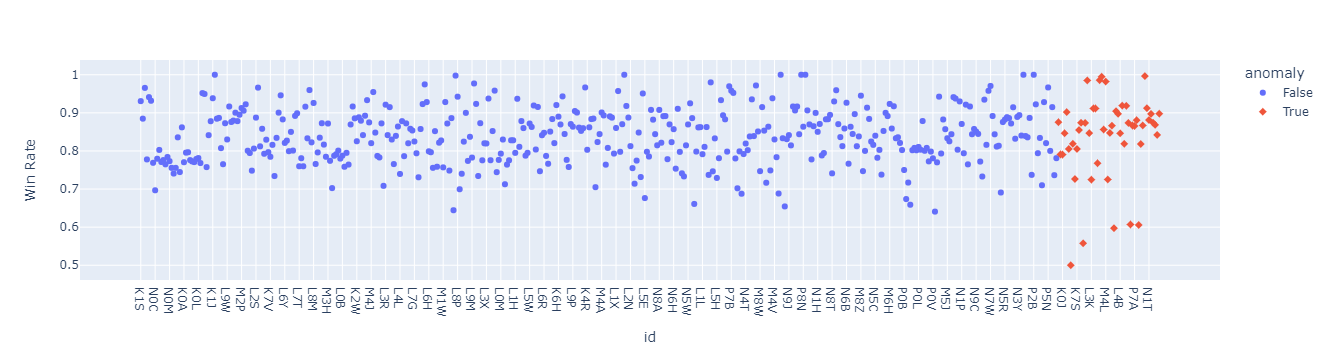

In [19]:
detector.graph(no_geo=True)

#### Ex. 2:
 - LOF
 - One metrics column
 - No automatic tuning

In [20]:
detector = CategoricalAnomalyDetector(gdf,model_type='LocalOutlierFactor', metrics_column='Win Rate' ,category_column='id')
model = detector.create_model()

Would you like to automatically tune hyperparameters? no


In [21]:
model.get_params()

{'algorithm': 'auto',
 'contamination': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 20,
 'novelty': False,
 'p': 2}

In [22]:
lof_res_tuned = detector.predict()

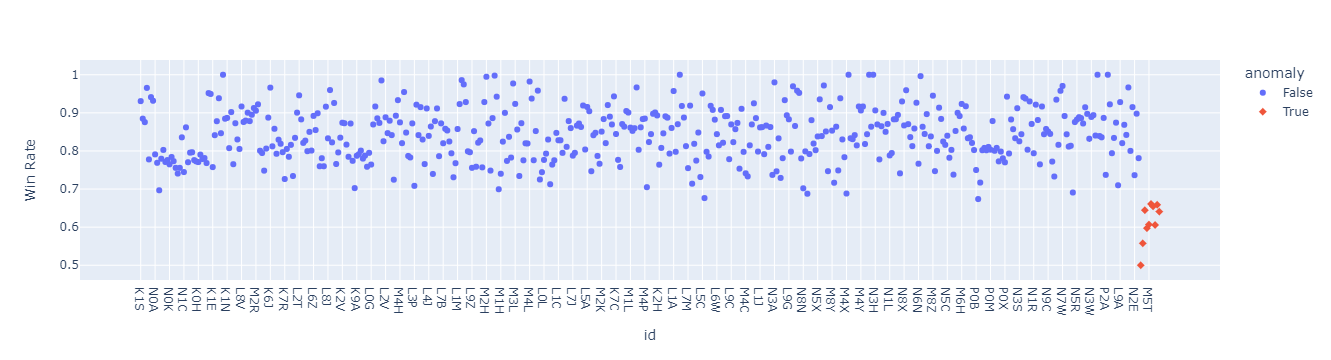

In [23]:
detector.graph(no_geo=True)

#### Ex. 3:
 - LOF
 - Multi metrics column
 - automatic tuning

In [7]:
detector = CategoricalAnomalyDetector(gdf,model_type='LocalOutlierFactor', metrics_column=['bids','impressions','clicks','spend'],category_column='id')
model = detector.create_model()

Would you like to automatically tune hyperparameters? yes


  0%|          | 0/100 [00:00<?, ?it/s]

Automatically tuning parameters


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


Tuned LOF Parameters : {'k': 2, 'c': 0.1}


In [8]:
model.get_params()

{'algorithm': 'auto',
 'contamination': 0.1,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'novelty': False,
 'p': 2}

In [9]:
lof_res_tuned_multi = detector.predict()

C:\Users\Kristopher\anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


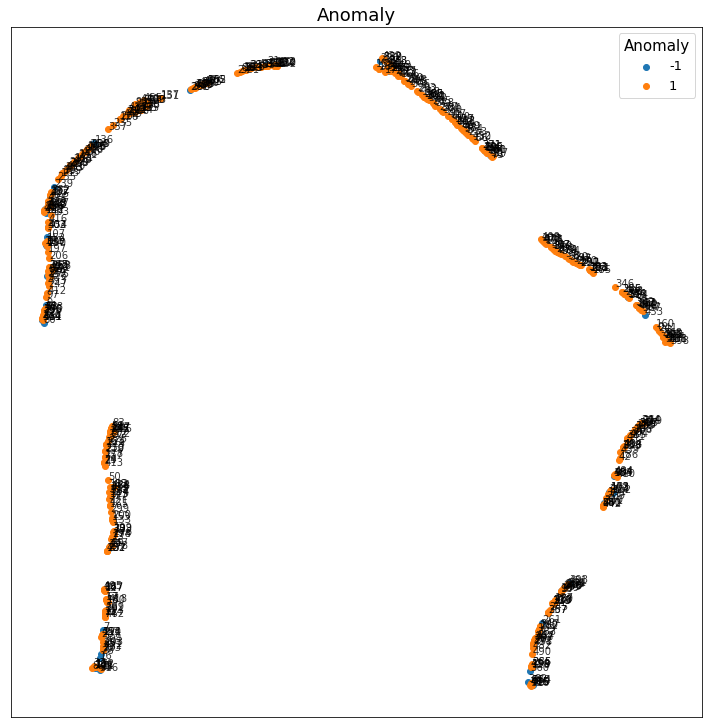

In [10]:
detector.graph(no_geo=True)

In [7]:
detector = CategoricalAnomalyDetector(gdf,model_type='LocalOutlierFactor', metrics_column=['bids','impressions','clicks','spend'],category_column='id')
model = detector.create_model()

Would you like to automatically tune hyperparameters? no


In [9]:
lof_multi = detector.predict()

In [3]:
detector.graph()

#### Ex. 4:
 - LODA
 - One metrics column

In [11]:
detector = CategoricalAnomalyDetector(gdf,model_type='LODA', metrics_column=['Win Rate'],category_column='id')
model = detector.create_model()

In [12]:
loda_res = detector.predict()

In [14]:
loda_res.loc[loda_res['score'] == -1]

,id,PRUID,PRNAME,geometry,bids,impressions,clicks,spend,Win Rate,CTR,score,anomaly
7,N0A,35,Ontario,"MULTIPOLYGON (((7203303.683 856529.531, 720376...",55306,43745,77,507.537716,0.790963,0.001760,-1,True
8,N0B,35,Ontario,"MULTIPOLYGON (((7150386.106 928469.066, 715216...",111602,85809,95,995.997688,0.768884,0.001107,-1,True
11,N0G,35,Ontario,"POLYGON ((7074649.000 986065.691, 7075239.151 ...",108232,86872,129,1007.691906,0.802646,0.001485,-1,True
12,N0H,35,Ontario,"POLYGON ((7067798.240 1083586.060, 7070871.029...",117864,90879,135,1055.030184,0.771050,0.001485,-1,True
15,N0L,35,Ontario,"MULTIPOLYGON (((7072383.883 827224.697, 707303...",48413,37960,45,440.227532,0.784087,0.001185,-1,True
16,N0M,35,Ontario,"MULTIPOLYGON (((7048401.729 911761.554, 704816...",98292,75988,125,881.693344,0.773084,0.001645,-1,True
23,K0A,35,Ontario,"MULTIPOLYGON (((7482045.103 1196752.829, 74820...",205177,158066,212,1835.951812,0.770388,0.001341,-1,True
25,K0C,35,Ontario,"POLYGON ((7550149.277 1216389.163, 7550426.860...",72368,57650,83,668.936913,0.796623,0.001440,-1,True
26,K0E,35,Ontario,"MULTIPOLYGON (((7472842.569 1117281.837, 74728...",85344,66221,100,768.509401,0.775930,0.001510,-1,True
27,K0G,35,Ontario,"MULTIPOLYGON (((7486734.166 1157795.989, 74867...",62002,47898,89,556.465280,0.772523,0.001858,-1,True


In [1]:
detector.graph()

#### Ex. 5:
 - Isolation Forest
 - One metrics column
 - User selected parameters

In [17]:
detector = CategoricalAnomalyDetector(gdf,model_type='IsolationForest', metrics_column=['Win Rate'],category_column='id')
model = detector.create_model(contamination=0.1, random_state=42)
model.get_params()

{'bootstrap': False,
 'contamination': 0.1,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [18]:
loda_res = detector.predict()
loda_res.loc[loda_res['score'] == -1]

,id,PRUID,PRNAME,geometry,bids,impressions,clicks,spend,Win Rate,CTR,score,anomaly
3,K1R,35,Ontario,"POLYGON ((7471696.651 1189493.206, 7471754.489...",232,224,0,2.606712,0.965517,0.000000,-1,True
9,N0C,35,Ontario,"POLYGON ((7106723.460 1003461.226, 7107357.117...",6203,4322,4,50.283437,0.696760,0.000925,-1,True
40,K1L,35,Ontario,"MULTIPOLYGON (((7474292.489 1193767.297, 74743...",16,16,0,0.186930,1.000000,0.000000,-1,True
63,K6J,35,Ontario,"POLYGON ((7553008.134 1169665.269, 7553103.654...",207,200,3,2.324331,0.966184,0.015000,-1,True
64,K6K,35,Ontario,"POLYGON ((7557254.366 1174426.051, 7557264.954...",4,2,0,0.023261,0.500000,0.000000,-1,True
93,L8K,35,Ontario,"POLYGON ((7198732.111 875791.840, 7198815.737 ...",1618,1553,1,18.099752,0.959827,0.000644,-1,True
105,M3K,35,Ontario,"POLYGON ((7216374.394 936927.126, 7216384.360 ...",226,126,0,1.480185,0.557522,0.000000,-1,True
106,K8V,35,Ontario,"POLYGON ((7360614.371 1019071.277, 7360640.214...",2326,1634,1,19.038598,0.702494,0.000612,-1,True
119,K2A,35,Ontario,"POLYGON ((7467792.817 1186207.680, 7467806.591...",67,66,0,0.765942,0.985075,0.000000,-1,True
130,K9H,35,Ontario,"POLYGON ((7296736.529 1026946.140, 7296920.954...",617,589,0,6.856989,0.954619,0.000000,-1,True


In [2]:
detector.graph()